# Schedule Risk Analysis Distributions

The following are some distributions commonly used in Schedule Risk Analysis (SRA).

* [Triangular](https://en.wikipedia.org/wiki/Triangular_distribution)
* [Beta](https://en.wikipedia.org/wiki/Beta_distribution)
* [Beta Rectangular](https://en.wikipedia.org/wiki/Beta_rectangular_distribution)
* [Doubly-Truncated](https://en.wikipedia.org/wiki/Truncated_normal_distribution)
* [Log-Normal](https://en.wikipedia.org/wiki/Log-normal_distribution)
* [Weibull](https://en.wikipedia.org/wiki/Weibull_distribution)

In this notebook, we will create classes to represet each distribution. In general, the classes will store the parameters, and three methods are available.

* `pdf` to compute the probability of a sample, `x`
* `cdf` to compute the cummulative distribution within a range `a` (low end) and `b` (high end)
* `rvs` to sample from the distribution

Of particular interest is the `rvs` method, which may be used in `Monte Carlo` simulation in [SRA](https://www.pmknowledgecenter.com/dynamic_scheduling/risk/schedule-risk-analysis-how-measure-your-baseline-schedule%E2%80%99s-sensitivity). Metrics such as 

* [Criticality Index](https://en.wikipedia.org/wiki/Criticality_index) (CI): measures the probability that an activity is on the critical path
* Significance Index (SI): measures the relative importance of an activity
* Schedule Sensitivity Index (SSI): measures the relative imporance of an activity taking CI into account
* Cruciality Index (CRI): measures the correlation between the activity duration and total project duration

## Triangular

The Triangular distribution is sometimes called a `three-point estimate` since it requires 3 parameters to create the distribution and the distribution's probability density shape ends up looking like a triangle. The parameters are

* `a` minimum duration,
* `m` expected duration, and
* `b` maximum duration.

The probability density function (PDF) for the triangular distribution is as follows.

$f(x) =
\begin{cases}
0 & \text{for } x < a, \\
\frac{2(x-a)}{(b-a)(c-a)} & \text{for } a \le x < c, \\
\frac{2}{b-a} & \text{for } x = c, \\
\frac{2(b-x)}{(b-a)(b-c)} & \text{for } c < x \le b, \\
0 & \text{for } b < x.
\end{cases}$

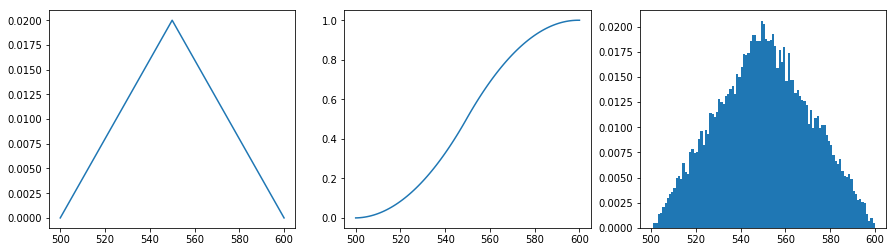

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform

np.random.seed(37)

class Triangle(object):
    def __init__(self, a, m, b):
        self.a = a
        self.m = m
        self.b = b
    
    def pdf(self, x):
        a, m, b = self.a, self.m, self.b
        
        if b < x < a:
            return 0.0
        elif a <= x < m:
            return (2 * (x - a)) / ((b - a) * (m - a))
        elif x == m:
            return (2 / (b - a))
        elif m < x <= b:
            return (2 * (b - x)) / ((b - a) * (b - m))
        raise Exception(f'No conditions satisifed x={x}, {a}, {m}, {b}')
        
    def cdf(self):
        p = np.array([self.pdf(x) for x in range(a, b+1)])
        c = p.cumsum()
        return c
    
    def rvs(self, size=1):
        a, b = self.a, self.b
        
        o = {i:v for i, v in enumerate(range(a, b+1))}
        c = self.cdf()
        u = uniform(size=size)
        s = [o[np.argmax(c >= x)] for x in u]
        return np.array(s)
    
a, m, b = 500, 550, 600

d = Triangle(a, m, b)

p = [d.pdf(x) for x in range(a, b+1)]
c = d.cdf()
s = d.rvs(size=20000)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
_ = ax[0].plot(list(range(a, b+1)), p)
_ = ax[1].plot(list(range(a, b+1)), c)
_ = ax[2].hist(s, bins=list(range(a, b+1)), density=True)

## Beta

The Beta distribution is smoother and curved compared to the Triangular distribution. It is parameterized by the following.

* `a` minimum duration
* `b` maximum duration
* $\theta_1$ shape parameter
* $\theta_2$ shape parameter

Note that $\theta_1$ and $\theta_2$ are positive and modified to make the the distribution left ($\theta_1 > \theta_2$) or right skewed ($\theta_1 < \theta_2$). The PDF of the Beta distribution is defined as follows.

$f(x) = \phi \frac{\Gamma(\theta_1 + \theta_2)}{\Gamma(\theta_1) \Gamma(\theta_2) (b - a)^{\theta_1 + \theta_2 - 1}}$

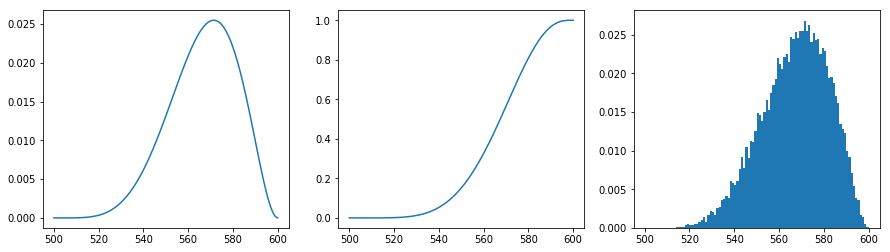

In [2]:
from scipy.special import gamma

class Beta(object):
    def __init__(self, a, b, theta_1, theta_2):
        self.a = a
        self.b = b
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        
    def pdf(self, x):
        a, b, theta_1, theta_2 = self.a, self.b, self.theta_1, self.theta_2
        
        p = gamma(theta_1 + theta_2)
        p = p / gamma(theta_1)
        p = p / gamma(theta_2)
        p = p / (b - a)**(theta_1 + theta_2 - 1)
        p = p * (x - a)**(theta_1 - 1)
        p = p * (b - x)**(theta_2 - 1)
        return p

    def cdf(self):
        p = np.array([self.pdf(x) for x in range(a, b+1)])
        c = p.cumsum()
        return c

    def rvs(self, size=1):
        a, b = self.a, self.b
        
        o = {i:v for i, v in enumerate(range(a, b+1))}
        c = self.cdf()
        u = uniform(size=size)
        s = [o[np.argmax(c >= x)] for x in u]
        return np.array(s)
    
a, b = 500, 600
theta_1, theta_2 = 6, 3

d = Beta(a, b, theta_1, theta_2)

p = [d.pdf(x) for x in range(a, b+1)]
c = d.cdf()
s = d.rvs(size=20000)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
_ = ax[0].plot(list(range(a, b+1)), p)
_ = ax[1].plot(list(range(a, b+1)), c)
_ = ax[2].hist(s, bins=list(range(a, b+1)), density=True)

## Beta Rectangular

The Beta Rectangular distribution is a mixture distribution of the Beta and Uniform distributions. It allows for an estimator's judgement to vary between Beta and complete uncertainty (Uniform). The parameters for a Beta Rectangular distribution are as follows.

* `a` minimum duration
* `b` maximum duration
* $\theta_1$ shape parameter
* $\theta_2$ shape parameter
* $\theta$ mixing parameter

Note that when $\theta=1$, then the Beta distribution is recovered, and when $\theta=0$, then the Uniform distribution is recovered. The parameter $\theta$ is called the `mixing parameter`. The PDF of the Beta Rectangular is defined as follows.

$f(x) = \phi \frac{\Gamma(\theta_1 + \theta_2)}{\Gamma(\theta_1) \Gamma(\theta_2) (b - a)^{\theta_1 + \theta_2 - 1}} + \frac{1 - \theta}{b - a}$

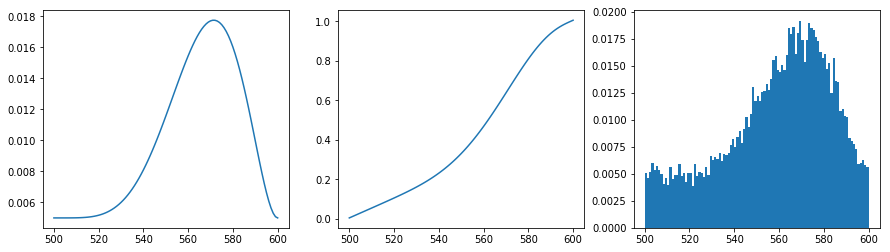

In [3]:
class BetaRect(object):
    def __init__(self, a, b, theta_1, theta_2, theta):
        self.a = a
        self.b = b
        self.theta_1 = theta_1
        self.theta_2 = theta_2
        self.theta = theta
        
    def pdf(self, x):
        a, b = self.a, self.b
        theta_1, theta_2, theta = self.theta_1, self.theta_2, self.theta
        
        p = gamma(theta_1 + theta_2)
        p = p / gamma(theta_1)
        p = p / gamma(theta_2)
        p = p / (b - a)**(theta_1 + theta_2 - 1)
        p = p * (x - a)**(theta_1 - 1)
        p = p * (b - x)**(theta_2 - 1)
        p = p * theta
        p = p + ((1 - theta) / (b - a))
        return p

    def cdf(self):
        p = np.array([self.pdf(x) for x in range(a, b+1)])
        c = p.cumsum()
        return c

    def rvs(self, size=1):
        a, b = self.a, self.b
        
        o = {i:v for i, v in enumerate(range(a, b+1))}
        c = self.cdf()
        u = uniform(size=size)
        s = [o[np.argmax(c >= x)] for x in u]
        return np.array(s)

a, b = 500, 600
theta_1, theta_2 = 6, 3
theta = 0.5

d = BetaRect(a, b, theta_1, theta_2, theta)

p = [d.pdf(x) for x in range(a, b+1)]
c = d.cdf()
s = d.rvs(size=20000)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
_ = ax[0].plot(list(range(a, b+1)), p)
_ = ax[1].plot(list(range(a, b+1)), c)
_ = ax[2].hist(s, bins=list(range(a, b+1)), density=True)

## Doubly-truncated

Compared to the Beta distribution, the Doubly-truncated distribution emphasizes more on the mode. It is parameterized by the following.

* `a` minimum duration
* `b` maximum duration
* $\mu$ mean
* $\sigma$ standard deviation

The PDF of the Doubly-truncated distribution is defined as follows.

$f(x)=\frac{\phi(\frac{x - \mu}{\sigma})}{\sigma( \Phi(\frac{b - \mu}{\sigma}) - \Phi(\frac{b - \mu}{\sigma}) )}$

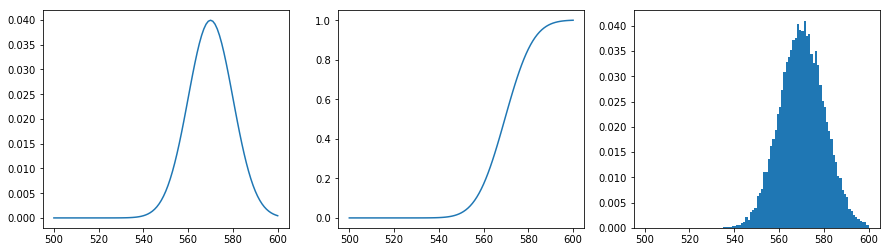

In [4]:
from scipy.stats import norm

class DoublyTruncated(object):
    def __init__(self, a, b, mu, sigma):
        self.a = a
        self.b = b
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, x):
        a, b = self.a, self.b
        mu, sigma = self.mu, self.sigma
        
        n = norm.pdf((x - mu) / sigma)
        d1 = norm.cdf((b - mu) / sigma)
        d2 = norm.cdf((a - mu) / sigma)
        d = sigma * (d1 - d2)
        p = n / d
        return p

    def cdf(self):
        p = np.array([self.pdf(x) for x in range(a, b+1)])
        c = p.cumsum()
        return c

    def rvs(self, size=1):
        a, b = self.a, self.b
        
        o = {i:v for i, v in enumerate(range(a, b+1))}
        c = self.cdf()
        u = uniform(size=size)
        s = [o[np.argmax(c >= x)] for x in u]
        return np.array(s)

a, b = 500, 600
mu, sigma = 570, 10

d = DoublyTruncated(a, b, mu, sigma)

p = [d.pdf(x) for x in range(a, b+1)]
c = d.cdf()
s = d.rvs(size=20000)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
_ = ax[0].plot(list(range(a, b+1)), p)
_ = ax[1].plot(list(range(a, b+1)), c)
_ = ax[2].hist(s, bins=list(range(a, b+1)), density=True)

## Log-normal

The Log-normal distribution is used in SRA when activities are right-skewed. This distribution has the following parameters.

* $\mu$ mean
* $\sigma$ standard deviation

The PDF of the Log-normal distribution is defined as follows.

$f(x)=\frac{1}{x} \frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{(\ln x-\mu)^2}{2\sigma^2}\right)$

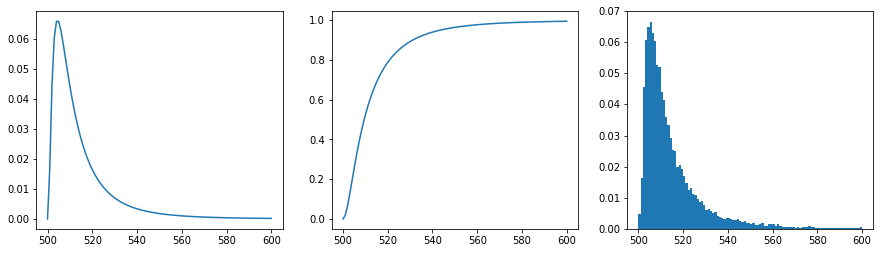

In [5]:
from scipy.stats import lognorm

class LogNormal(object):
    def __init__(self, a, b, s, mu, sigma):
        self.a = a
        self.b = b
        self.s = s
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, x):
        s, mu, sigma = self.s, self.mu, self.sigma
        
        return lognorm.pdf(x, s, loc=mu, scale=sigma)

    def cdf(self):
        a, b = self.a, self.b
        
        p = np.array([self.pdf(x) for x in range(a, b+1)])
        c = p.cumsum()
        return c

    def rvs(self, size=1):
        a, b = self.a, self.b
        
        o = {i:v for i, v in enumerate(range(a, b+1))}
        c = self.cdf()
        u = uniform(size=size)
        s = [o[np.argmax(c >= x)] for x in u]
        return np.array(s)

a, b = 500, 600
mu, sigma, s = 500, 10, 0.9

d = LogNormal(a, b, s, mu, sigma)

p = [d.pdf(x) for x in range(a, b+1)]
c = d.cdf()
s = d.rvs(size=20000)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
_ = ax[0].plot(list(range(a, b+1)), p)
_ = ax[1].plot(list(range(a, b+1)), c)
_ = ax[2].hist(s, bins=list(range(a, b+1)), density=True)

## Weibull

Compared to the Log-normal distribution, the Weibull distribution is used when activity durations are left-skewed. Its parameters are as follows.

* $\mu$ mean
* $\sigma$ standard deviation

The PDF of the Weibull is defined as follows.

$f(x;\lambda,k) =
\begin{cases}
\frac{k}{\lambda}\left(\frac{x}{\lambda}\right)^{k-1}e^{-(x/\lambda)^{k}} & x\geq0 ,\\
0 & x<0,
\end{cases}$

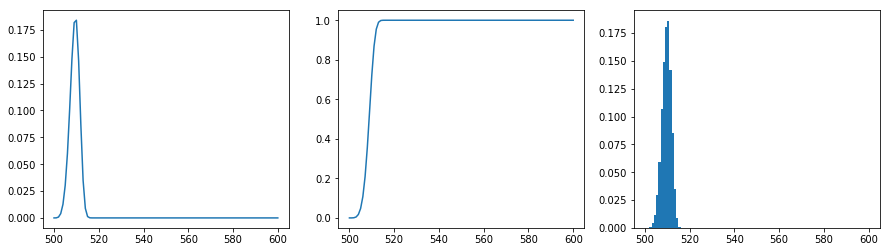

In [6]:
from scipy.stats import weibull_min

class Weibull(object):
    def __init__(self, a, b, s, mu, sigma):
        self.a = a
        self.b = b
        self.s = s
        self.mu = mu
        self.sigma = sigma
        
    def pdf(self, x):
        s, mu, sigma = self.s, self.mu, self.sigma
        
        return weibull_min.pdf(x, s, loc=mu, scale=sigma)

    def cdf(self):
        a, b = self.a, self.b
        
        p = np.array([self.pdf(x) for x in range(a, b+1)])
        c = p.cumsum()
        return c

    def rvs(self, size=1):
        a, b = self.a, self.b
        
        o = {i:v for i, v in enumerate(range(a, b+1))}
        c = self.cdf()
        u = uniform(size=size)
        s = [o[np.argmax(c >= x)] for x in u]
        return np.array(s)

a, b = 500, 600
mu, sigma, s = 500, 10, 5

d = Weibull(a, b, s, mu, sigma)

p = [d.pdf(x) for x in range(a, b+1)]
c = d.cdf()
s = d.rvs(size=20000)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
_ = ax[0].plot(list(range(a, b+1)), p)
_ = ax[1].plot(list(range(a, b+1)), c)
_ = ax[2].hist(s, bins=list(range(a, b+1)), density=True)